# <center>Machine Learning Project Code</center>

<a class="anchor" id="top"></a>

## <center>*02 - Simple Train & Modeling*</center>

** **



# Table of Contents  <br>


1. [Importing Libraries & Data](#1.-Importing-Libraries-&-Data) <br><br>
    
2. [Train-Test Split](#2.-Train-Test-Split)
    
   2.1 [Missing Values](#2.1-Missing-Values) <br>
    
   2.2 [Outliers](#2.2-Outliers) <br><br>
   
3. [Feature Selection](#3.-Feature-Selection) 

    3.1 [Scaling](#3.1-Scaling) <br>
    
    3.2 [Filter Based Methods](#3.2-Filter-Based-Methods) <br>

    3.3 [Wrapper Methods](#3.3-Wrapper-Methods) <br>
    
    3.4 [Embedded Methods](#3.4-Embedded-Methods) <br><br>
    
4. [Modeling](#4.-Modeling) <br><br>

5. [Export](#5.-Export)


** **

In this notebook we will start by spliting train and validation data using a simple Holdout Method. After doing so, more complex methods to fill missing values will be applied, and outliers will be addresses. Feature Selection will also be performed, followed by a Modeling section.

Data Scientist Manager: António Oliveira, **20211595**

Data Scientist Senior: Tomás Ribeiro, **20240526**

Data Scientist Junior: Gonçalo Pacheco, **20240695**

Data Analyst Senior: Gonçalo Custódio, **20211643**

Data Analyst Junior: Ana Caleiro, **20240696**


** ** 

# 1. Importing Libraries & Data
In this section, we set up the foundation for our project by importing the necessary Python libraries and loading the dataset. These libraries provide the tools for data manipulation, visualization, and machine learning modeling throughout the notebook. Additionally, we import the historical claims dataset, which forms the core of our analysis. 

In [3]:
import pandas as pd
import numpy as np

# Train-Test Split
from sklearn.model_selection import train_test_split

import preproc as p

# fs
from sklearn.feature_selection import VarianceThreshold
import feature_selection as fs

# models 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import metrics as m

pd.set_option('display.max_columns', None)
# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

**Import Data**

In [4]:
# Load training data
df = pd.read_csv('./data/train_data_EDA.csv', index_col = 'Claim Identifier')

# Load testing data
test = pd.read_csv('./data/test_data_EDA.csv', index_col = 'Claim Identifier')

# Display the first 3 rows of the training data
df.head(3)

,Age at Injury,Average Weekly Wage,Birth Year,Claim Injury Type,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Number of Dependents,Alternative Dispute Resolution Bin,Attorney/Representative Bin,Carrier Name Enc,Carrier Type freq,Carrier Type_1A. PRIVATE,Carrier Type_2A. SIF,Carrier Type_3A. SELF PUBLIC,Carrier Type_4A. SELF PRIVATE,County of Injury freq,COVID-19 Indicator Enc,District Name freq,Gender Enc,Gender_F,Gender_M,Medical Fee Region freq,Accident Date Year,Accident Date Month,Accident Date Day,Accident Date Day of Week,Assembly Date Year,Assembly Date Month,Assembly Date Day,Assembly Date Day of Week,C-2 Date Year,C-2 Date Month,C-2 Date Day,C-2 Date Day of Week,WCIO Codes,Insurance,Zip Code Valid,Industry Sector Count Enc,Age Group,C-3 Date Binary,First Hearing Date Binary
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5393875,31.0,0.00,1988.0,1,0.0,44.0,27,10,62,1.0,0,0,399,285367,1,0,0,0,3355,0,44646,0,0,1,135885,2019.0,12.0,30.0,0.0,2020,1,1,2,2019.0,12.0,31.0,1.0,271062,1,0,103330,1,0,0
5393091,46.0,1745.93,1973.0,3,4.0,23.0,97,49,38,4.0,0,1,1023,285367,1,0,0,0,760,0,40449,1,1,0,135885,2019.0,8.0,30.0,4.0,2020,1,1,2,2020.0,1.0,1.0,2.0,974938,1,0,69053,1,1,1
5393889,40.0,1434.80,1979.0,3,0.0,56.0,79,7,10,6.0,0,0,689,285367,1,0,0,0,17450,0,86171,0,0,1,85033,2019.0,12.0,6.0,4.0,2020,1,1,2,2020.0,1.0,1.0,2.0,79710,1,0,57495,1,0,0


# 2. Train-Test Split
The train-test split is a crucial technique used to assess model performance by dividing the dataset into training and testing subsets. This ensures that the model is evaluated on unseen data, helping to prevent overfitting and providing an unbiased performance estimate. 

<a href="#top">Top &#129033;</a>

**Holdout Method**

In [5]:
# Split the DataFrame into features (X) and target variable (y)
X = df.drop('Claim Injury Type', axis=1) 
y = df['Claim Injury Type']  

In [6]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify = y) 


# 2.1 Missing Values

<a href="#top">Top &#129033;</a>

In [7]:
X_train.isna().sum()

Age at Injury                             0
Average Weekly Wage                   22968
Birth Year                            23204
IME-4 Count                               0
Industry Code                             0
WCIO Cause of Injury Code                 0
WCIO Nature of Injury Code                0
WCIO Part Of Body Code                    0
Number of Dependents                      0
Alternative Dispute Resolution Bin        0
Attorney/Representative Bin               0
Carrier Name Enc                          0
Carrier Type freq                         0
Carrier Type_1A. PRIVATE                  0
Carrier Type_2A. SIF                      0
Carrier Type_3A. SELF PUBLIC              0
Carrier Type_4A. SELF PRIVATE             0
County of Injury freq                     0
COVID-19 Indicator Enc                    0
District Name freq                        0
Gender Enc                                0
Gender_F                                  0
Gender_M                        

**Accident Date**

Fill Year, Month and Day with median. Then recompute full date and from there fill missing values in Day of Week

In [8]:
# Define median values for Accident-related features from the training dataset
accident_med = {
    'Accident Date Year': round(X_train['Accident Date Year'].median()), 
    'Accident Date Month': round(X_train['Accident Date Month'].median()),
    'Accident Date Day': round(X_train['Accident Date Day'].median() ) 
}

Fill with median

In [9]:
X_train['Accident Date Year'].fillna(accident_med['Accident Date Year'], inplace=True)  
X_train['Accident Date Month'].fillna(accident_med['Accident Date Month'], inplace=True)
X_train['Accident Date Day'].fillna(accident_med['Accident Date Day'], inplace=True) 

X_val['Accident Date Year'].fillna(accident_med['Accident Date Year'], inplace=True)  
X_val['Accident Date Month'].fillna(accident_med['Accident Date Month'], inplace=True)
X_val['Accident Date Day'].fillna(accident_med['Accident Date Day'], inplace=True) 


test['Accident Date Year'].fillna(accident_med['Accident Date Year'], inplace=True)  
test['Accident Date Month'].fillna(accident_med['Accident Date Month'], inplace=True)
test['Accident Date Day'].fillna(accident_med['Accident Date Day'], inplace=True) 

Convert to Integers

In [10]:
X_train['Accident Date Year'] = X_train['Accident Date Year'].astype('Int64')
X_train['Accident Date Month'] = X_train['Accident Date Month'].astype('Int64')
X_train['Accident Date Day'] = X_train['Accident Date Day'].astype('Int64')

X_val['Accident Date Year'] = X_val['Accident Date Year'].astype('Int64')
X_val['Accident Date Month'] = X_val['Accident Date Month'].astype('Int64')
X_val['Accident Date Day'] = X_val['Accident Date Day'].astype('Int64')


test['Accident Date Year'] = test['Accident Date Year'].astype('Int64')
test['Accident Date Month'] = test['Accident Date Month'].astype('Int64')
test['Accident Date Day'] = test['Accident Date Day'].astype('Int64')

Identify missing values and recompute Accident date to fill Day of the week

In [11]:
# select missing
missing_dayofweek_train = X_train['Accident Date Day of Week'].isnull()

missing_dayofweek_val = X_val['Accident Date Day of Week'].isnull()

missing_dayofweek_test = test['Accident Date Day of Week'].isnull()

In [12]:
# compute temp accident date for missing values in day of week
X_train.loc[missing_dayofweek_train, 'TEMP Accident Date'] = pd.to_datetime(
    X_train.loc[missing_dayofweek_train, ['Accident Date Year', 'Accident Date Month', 'Accident Date Day']].astype(str).agg('-'.join, axis=1),
    errors='coerce'
)

X_val.loc[missing_dayofweek_val, 'TEMP Accident Date'] = pd.to_datetime(
    X_val.loc[missing_dayofweek_val, ['Accident Date Year', 'Accident Date Month', 'Accident Date Day']].astype(str).agg('-'.join, axis=1),
    errors='coerce'
)


test.loc[missing_dayofweek_test, 'TEMP Accident Date'] = pd.to_datetime(
    test.loc[missing_dayofweek_test, ['Accident Date Year', 'Accident Date Month', 'Accident Date Day']].astype(str).agg('-'.join, axis=1),
    errors='coerce'
)

In [13]:
X_train.loc[missing_dayofweek_train, 'Accident Date Day of Week'] = X_train.loc[missing_dayofweek_train, 'TEMP Accident Date'].dt.dayofweek

X_val.loc[missing_dayofweek_val, 'Accident Date Day of Week'] = X_val.loc[missing_dayofweek_val, 'TEMP Accident Date'].dt.dayofweek


test.loc[missing_dayofweek_test, 'Accident Date Day of Week'] = test.loc[missing_dayofweek_test, 'TEMP Accident Date'].dt.dayofweek

**C-2 Date**

Fill Year, Month and Day with median. Then recompute full date and from there fill missing values in Day of Week

In [14]:
# Create a dictionary with the median values of 'C-2 Year', 'C-2 Month', and 'C-2 Day' from the training set
c2_med = {
    'C-2 Date Year': round(X_train['C-2 Date Year'].median()),
    'C-2 Date Month': round(X_train['C-2 Date Month'].median()),
    'C-2 Date Day': round(X_train['C-2 Date Day'].median())
}

Fill with median

In [15]:
X_train['C-2 Date Year'].fillna(c2_med['C-2 Date Year'], inplace=True)  
X_train['C-2 Date Month'].fillna(c2_med['C-2 Date Month'], inplace=True)
X_train['C-2 Date Day'].fillna(c2_med['C-2 Date Day'], inplace=True) 

X_val['C-2 Date Year'].fillna(c2_med['C-2 Date Year'], inplace=True)  
X_val['C-2 Date Month'].fillna(c2_med['C-2 Date Month'], inplace=True)
X_val['C-2 Date Day'].fillna(c2_med['C-2 Date Day'], inplace=True) 

test['C-2 Date Year'].fillna(c2_med['C-2 Date Year'], inplace=True)  
test['C-2 Date Month'].fillna(c2_med['C-2 Date Month'], inplace=True)
test['C-2 Date Day'].fillna(c2_med['C-2 Date Day'], inplace=True) 

Convert to Integers

In [16]:
X_train['C-2 Date Year'] = X_train['C-2 Date Year'].astype('Int64')
X_train['C-2 Date Month'] = X_train['C-2 Date Month'].astype('Int64')
X_train['C-2 Date Day'] = X_train['C-2 Date Day'].astype('Int64')

X_val['C-2 Date Year'] = X_val['C-2 Date Year'].astype('Int64')
X_val['C-2 Date Month'] = X_val['C-2 Date Month'].astype('Int64')
X_val['C-2 Date Day'] = X_val['C-2 Date Day'].astype('Int64')

test['C-2 Date Year'] = test['C-2 Date Year'].astype('Int64')
test['C-2 Date Month'] = test['C-2 Date Month'].astype('Int64')
test['C-2 Date Day'] = test['C-2 Date Day'].astype('Int64')

Identify missing values and recompute Accident date to fill Day of the week

In [17]:
# select missing
missing_dayofweek_train = X_train['C-2 Date Day of Week'].isnull()

missing_dayofweek_val = X_val['C-2 Date Day of Week'].isnull()

missing_dayofweek_test = test['C-2 Date Day of Week'].isnull()

In [18]:
# compute temp accident date for missing values in day of week
X_train.loc[missing_dayofweek_train, 'TEMP C-2 Date'] = pd.to_datetime(
    X_train.loc[missing_dayofweek_train, ['C-2 Date Year', 'C-2 Date Month', 'C-2 Date Day']].astype(str).agg('-'.join, axis=1),
    errors='coerce'
)

X_val.loc[missing_dayofweek_val, 'TEMP C-2 Date'] = pd.to_datetime(
    X_val.loc[missing_dayofweek_val, ['C-2 Date Year', 'C-2 Date Month', 'C-2 Date Day']].astype(str).agg('-'.join, axis=1),
    errors='coerce'
)

test.loc[missing_dayofweek_test, 'TEMP C-2 Date'] = pd.to_datetime(
    test.loc[missing_dayofweek_test, ['C-2 Date Year', 'C-2 Date Month', 'C-2 Date Day']].astype(str).agg('-'.join, axis=1),
    errors='coerce'
)

In [19]:
X_train.loc[missing_dayofweek_train, 'C-2 Date Day of Week'] = X_train.loc[missing_dayofweek_train, 'TEMP C-2 Date'].dt.dayofweek

X_val.loc[missing_dayofweek_val, 'C-2 Date Day of Week'] = X_val.loc[missing_dayofweek_val, 'TEMP C-2 Date'].dt.dayofweek

test.loc[missing_dayofweek_test, 'C-2 Date Day of Week'] = test.loc[missing_dayofweek_test, 'TEMP C-2 Date'].dt.dayofweek

Remove temporary variables

In [20]:
X_train.drop(['TEMP Accident Date', 'TEMP C-2 Date'], 
        axis = 1, inplace = True)

X_val.drop(['TEMP Accident Date', 'TEMP C-2 Date'], 
        axis = 1, inplace = True)

test.drop(['TEMP Accident Date', 'TEMP C-2 Date'], 
        axis = 1, inplace = True)

**Birth Year**

To fill the missing values, we will start by creating a mask, which filters for observations where `Age at Injury` and `Accident Date Year` are not missing, and when `Birth Year` is either missing or zero. Since we are going to use `Age at Injury` and `Accident Date Year` to compute `Birth Year`, ensuring those two variables are no missing is crucial. Then, we also decided to recompute the `Birth Year` when it is 0, since it is impossible to have 0 as a `Birth Year`.

In [21]:
train_mask = X_train['Accident Date Year'].notna() & X_train['Age at Injury'].notna() & \
           (X_train['Birth Year'].isna() | (X_train['Birth Year'] == 0))


val_mask = (X_val['Accident Date Year'].notna() &  X_val['Age at Injury'].notna() &  
    (X_val['Birth Year'].isna() | (X_val['Birth Year'] == 0)))

test_mask = test['Accident Date Year'].notna() & test['Age at Injury'].notna() & \
           (test['Birth Year'].isna() | (test['Birth Year'] == 0))

In [22]:
X_train.loc[train_mask, 'Birth Year'] = X_train['Accident Date Year'] - X_train['Age at Injury']

X_val.loc[val_mask, 'Birth Year'] = X_val['Accident Date Year'] - X_val['Age at Injury']

test.loc[test_mask, 'Birth Year'] = test['Accident Date Year'] - test['Age at Injury']

**Average Weekly Wage**

In [23]:
X_train['Average Weekly Wage'] = p.ball_tree_impute(X_train, 'Average Weekly Wage', n_neighbors=100)

X_val['Average Weekly Wage'] = p.ball_tree_impute(X_val, 'Average Weekly Wage', n_neighbors=100)

test['Average Weekly Wage'] = p.ball_tree_impute(test, 'Average Weekly Wage', n_neighbors=100)

In [24]:
# from imblearn.combine import SMOTEENN
# from collections import Counter

# # Assume X and y are your features and target variable
# smote_enn = SMOTEENN(random_state=42)
# X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# # Check the new class distribution
# print("Class distribution after SMOTEENN:", Counter(y_train))

# import play_song as s
# s.play_('audio.mp3')

# 2.2 Outliers

<a href="#top">Top &#129033;</a>

### Outlier Detection

To detect outliers we will use a function that plots boxplots and identifies outliers based on the Interquartile Range method. This function will also add to a list all columns with a higher percentage of outliers than a previously set threshold.

In [ ]:
p.detect_outliers_iqr(X_train, 0.0001)

### Dealing With Outliers

Here we will apply some techniques to attempt to deal with outliers, either by applying some transformations or removing them. Our goal is to not remove more than 5% of observations. To keep track of this metrics, we will start by saving the initial length of the dataset.

In [25]:
X_train_copy = X_train.copy()
X_train_len = len(X_train_copy)

**Average Weekly Wage**

Set a threshold

In [26]:
# dropped_len_wage = len(X_train[X_train['Average Weekly Wage'] > 7300])

# X_train = X_train[X_train['Average Weekly Wage'] <= 7300]

Winsorization for `Average Weekly Wage`

In [27]:
upper_limit = X_train['Average Weekly Wage'].quantile(0.99)
lower_limit = X_train['Average Weekly Wage'].quantile(0.01)
X_train['Average Weekly Wage'] = X_train['Average Weekly Wage'].clip(lower=lower_limit, upper=upper_limit)

Apply a square root transformation

In [28]:
X_train['Average Weekly Wage Sqrt'] = np.sqrt(X_train['Average Weekly Wage'])

X_val['Average Weekly Wage Sqrt'] = np.sqrt(X_val['Average Weekly Wage'])

test['Average Weekly Wage Sqrt'] = np.sqrt(test['Average Weekly Wage'])

**Birth Year**

In [29]:
dropped_len_birth_year = len(X_train[X_train['Birth Year'] < 1932.5])

X_train = X_train[X_train['Birth Year'] > 1932.5]

**IME-4 Count**

In [30]:
X_train['IME-4 Count Log'] = np.log1p(X_train['IME-4 Count'])
X_train['IME-4 Count Double Log'] = np.log1p(X_train['IME-4 Count Log'])

X_val['IME-4 Count Log'] = np.log1p(X_val['IME-4 Count'])
X_val['IME-4 Count Double Log'] = np.log1p(X_val['IME-4 Count Log'])

test['IME-4 Count Log'] = np.log1p(test['IME-4 Count'])
test['IME-4 Count Double Log'] = np.log1p(test['IME-4 Count Log'])

**Alternative Dispute Resolution Bin**

In [31]:
dropped_len_alt_disp = len(X_train[X_train['Alternative Dispute Resolution Bin'] == 1])

X_train = X_train[X_train['Alternative Dispute Resolution Bin'] == 0]

**Covid-19 Indicator Enc**

This feature has 21k observations with Covid-19 Indicator equal to 1, therefore they will not be dropped. 

In [32]:
X_train[X_train['COVID-19 Indicator Enc'] == 1]

,Age at Injury,Average Weekly Wage,Birth Year,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Number of Dependents,Alternative Dispute Resolution Bin,Attorney/Representative Bin,Carrier Name Enc,Carrier Type freq,Carrier Type_1A. PRIVATE,Carrier Type_2A. SIF,Carrier Type_3A. SELF PUBLIC,Carrier Type_4A. SELF PRIVATE,County of Injury freq,COVID-19 Indicator Enc,District Name freq,Gender Enc,Gender_F,Gender_M,Medical Fee Region freq,Accident Date Year,Accident Date Month,Accident Date Day,Accident Date Day of Week,Assembly Date Year,Assembly Date Month,Assembly Date Day,Assembly Date Day of Week,C-2 Date Year,C-2 Date Month,C-2 Date Day,C-2 Date Day of Week,WCIO Codes,Insurance,Zip Code Valid,Industry Sector Count Enc,Age Group,C-3 Date Binary,First Hearing Date Binary,Average Weekly Wage Sqrt,IME-4 Count Log,IME-4 Count Double Log
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5471127,60.0,0.00,1960.0,0.0,56.0,83,83,99,0.0,0,0,29,285367,1,0,0,0,30014,1,270778,0,0,1,265981,2020,4,9,3.0,2020,4,23,3,2020,4,23,3.0,838399,1,0,57495,1,0,0,0.000000,0.000000,0.000000
5474976,44.0,0.00,1975.0,0.0,72.0,83,83,60,5.0,0,0,706,285367,1,0,0,0,30014,1,270778,1,1,0,265981,2020,4,5,6.0,2020,4,30,3,2020,4,30,3.0,838360,1,0,103330,1,1,1,0.000000,0.000000,0.000000
5479360,32.0,598.89,1987.0,0.0,62.0,83,83,65,2.0,0,0,127,285367,1,0,0,0,53207,1,270778,1,1,0,33472,2020,3,1,6.0,2020,5,8,4,2020,5,8,4.0,838365,1,0,260939,1,0,0,24.472229,0.000000,0.000000
5690440,47.0,0.00,1973.0,0.0,49.0,83,83,91,2.0,0,0,200,285367,1,0,0,0,60430,1,60536,0,0,1,265981,2021,3,15,0.0,2021,3,30,1,2021,3,29,0.0,838391,1,0,54023,1,0,0,0.000000,0.000000,0.000000
5596285,41.0,0.00,1978.0,0.0,62.0,83,83,60,3.0,0,1,1119,111144,0,1,0,0,39618,1,270778,1,1,0,265981,2020,4,6,0.0,2020,11,10,1,2020,11,16,0.0,838360,1,0,260939,1,1,1,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5891602,27.0,0.00,1994.0,0.0,53.0,83,83,60,2.0,0,0,1239,285367,1,0,0,0,60430,1,60536,0,0,1,265981,2021,12,23,3.0,2022,1,5,2,2022,1,5,2.0,838360,1,0,57495,1,0,0,0.000000,0.000000,0.000000
5474935,45.0,2423.79,1974.0,0.0,62.0,83,83,91,6.0,0,1,200,285367,1,0,0,0,53207,1,270778,1,1,0,33472,2020,3,23,0.0,2020,4,30,3,2020,4,30,3.0,838391,1,0,260939,1,0,1,49.232002,0.000000,0.000000
5486978,78.0,0.00,1941.0,5.0,62.0,83,83,90,0.0,0,0,127,285367,1,0,0,0,43580,1,270778,1,1,0,265981,2020,4,2,3.0,2020,5,22,4,2020,5,22,4.0,838390,1,0,260939,2,1,0,0.000000,1.791759,1.026672


**Accident Date Year**

In [33]:
dropped_len_accident_year =len(X_train[X_train['Accident Date Year'] < 2017])

X_train = X_train[X_train['Accident Date Year'] >= 2017]

**C-2 Date Year**

In [34]:
dropped_len_c2_year =len(X_train[X_train['C-2 Date Year'] < 2017])

X_train = X_train[X_train['C-2 Date Year'] >= 2017]

**Assess Decisions**

Since we dropped less than 5% of observations, we can continue to feature selection

In [35]:
len_dropped = dropped_len_wage + dropped_len_birth_year + dropped_len_alt_disp + dropped_len_accident_year + dropped_len_c2_year 

len_dropped / X_train_len

NameError: name 'dropped_len_wage' is not defined

Ensure y_train has the same indices as X_train

In [36]:
y_train = y_train[X_train.index]

**Cluster-based Filtering**

In [ ]:
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import RobustScaler

In [ ]:
# scaler = RobustScaler()
# scaled_data = scaler.fit_transform(X_train)

In [ ]:
# dbscan = DBSCAN()
# X_train['dbscan_cluster_1'] = dbscan.fit_predict(scaled_data)

In [ ]:
# X_train['dbscan_cluster_1'].value_counts()

In [ ]:
# import matplotlib.pyplot as plt
# # Create a bar chart of the number of customers in each cluster
# cluster_counts = X_train.groupby(['dbscan_cluster_1']).size()

# ax = cluster_counts.plot(kind='bar')

# # Add labels to the x and y axes
# plt.xlabel('Cluster')
# plt.ylabel('Number of Customers')
# plt.xticks(rotation=0)

# # Show the plot
# plt.show()

# 3. Feature Selection

<a href="#top">Top &#129033;</a>

In this section we will perform feature selection. We will start by splitting data into numeric, categorical or max 3 classes. Then, scaling will be applied. However, from the previous delivery we noted that the best performing models are Tree-Based, which are not sensitive to feature's scale, and therefore do not require scaling. Consequently, we will implement the same method for both scaled and unscaled numerical data, and compare the results.

In [37]:
X_train

,Age at Injury,Average Weekly Wage,Birth Year,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Number of Dependents,Alternative Dispute Resolution Bin,Attorney/Representative Bin,Carrier Name Enc,Carrier Type freq,Carrier Type_1A. PRIVATE,Carrier Type_2A. SIF,Carrier Type_3A. SELF PUBLIC,Carrier Type_4A. SELF PRIVATE,County of Injury freq,COVID-19 Indicator Enc,District Name freq,Gender Enc,Gender_F,Gender_M,Medical Fee Region freq,Accident Date Year,Accident Date Month,Accident Date Day,Accident Date Day of Week,Assembly Date Year,Assembly Date Month,Assembly Date Day,Assembly Date Day of Week,C-2 Date Year,C-2 Date Month,C-2 Date Day,C-2 Date Day of Week,WCIO Codes,Insurance,Zip Code Valid,Industry Sector Count Enc,Age Group,C-3 Date Binary,First Hearing Date Binary,Average Weekly Wage Sqrt,IME-4 Count Log,IME-4 Count Double Log
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5785935,49.0,744.06,1971.0,2.0,31.0,29,59,42,6.0,0,1,639,285367,1,0,0,0,58333,0,270778,1,1,0,265981,2021,8,5,3.0,2021,8,10,1,2021,8,10,1.0,295942,0,0,69053,1,1,0,27.277463,1.098612,0.741276
5980545,31.0,1157.33,1991.0,0.0,62.0,99,1,9,2.0,0,0,409,121920,0,0,1,0,39618,0,270778,1,1,0,265981,2022,4,5,1.0,2022,5,2,0,2022,4,30,5.0,9919,0,0,260939,1,0,1,34.019553,0.000000,0.000000
5552635,44.0,0.00,1976.0,0.0,49.0,80,52,56,3.0,0,0,906,285367,1,0,0,0,53207,0,270778,0,0,1,265981,2020,9,1,1.0,2020,9,4,4,2020,9,4,4.0,805256,1,0,54023,1,0,0,0.000000,0.000000,0.000000
5758039,25.0,0.00,1996.0,0.0,44.0,68,10,11,1.0,0,0,80,52788,0,0,0,1,53207,0,270778,0,0,1,265981,2021,6,10,3.0,2021,7,2,4,2021,7,2,4.0,681011,0,0,103330,1,0,0,0.000000,0.000000,0.000000
5951382,41.0,250.00,1980.0,0.0,48.0,45,49,9,4.0,0,1,48,52788,0,0,0,1,43580,0,270778,0,0,1,265981,2022,1,26,2.0,2022,3,25,4,2022,3,30,2.0,45499,0,0,54023,1,1,1,15.811388,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5837651,26.0,1244.56,1995.0,1.0,62.0,98,80,41,6.0,0,1,689,285367,1,0,0,0,25754,0,270778,0,0,1,53654,2021,10,15,4.0,2021,10,19,1,2021,10,19,1.0,988041,1,0,260939,1,1,1,35.278322,0.693147,0.526589
5781926,55.0,969.26,1966.0,7.0,62.0,74,10,90,1.0,0,1,251,285367,1,0,0,0,58333,0,270778,0,0,1,265981,2021,7,28,2.0,2021,8,4,2,2021,8,4,2.0,741090,0,0,260939,1,1,1,31.132941,2.079442,1.124748
5890060,57.0,794.09,1964.0,0.0,81.0,53,52,53,5.0,0,0,764,285367,1,0,0,0,30874,0,45605,1,1,0,135885,2021,11,11,3.0,2022,1,4,1,2022,1,4,1.0,535253,1,0,23106,1,0,0,28.179603,0.000000,0.000000


**Variable type split**

In [38]:
num = ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Number of Dependents',
       'Accident Date Year', 'Accident Date Month', 'Accident Date Day', 'Assembly Date Year', 
       'Assembly Date Month', 'Assembly Date Day', 'C-2 Date Year', 'C-2 Date Month', 'C-2 Date Day',
       'IME-4 Count Log', 'IME-4 Count Double Log', 'Average Weekly Wage Sqrt']

max3_class = ['Attorney/Representative Bin', 'Carrier Type_1A. PRIVATE', 'Carrier Type_2A. SIF',
              'Carrier Type_3A. SELF PUBLIC', 'Carrier Type_4A. SELF PRIVATE', 'COVID-19 Indicator Enc',
              'Gender Enc', 'Gender_F', 'Gender_M', 'Zip Code Valid', 'Age Group', 'C-3 Date Binary',
              'First Hearing Date Binary', 'Insurance']

categ = ['Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
         'WCIO Part Of Body Code', 'Carrier Name Enc', 'Carrier Type freq', 'County of Injury freq',
         'District Name freq', 'Medical Fee Region freq', 'Accident Date Day of Week', 'Assembly Date Day of Week',
         'C-2 Date Day of Week', 'WCIO Codes', 'Industry Sector Count Enc']

In [39]:
X_train_all_categ = pd.concat([X_train[categ], X_train[max3_class]], axis=1)
X_val_all_categ = pd.concat([X_val[categ], X_val[max3_class]], axis=1)

## 3.1 Scaling

In [ ]:
robust = RobustScaler()

In [ ]:
# Scaling the numerical features in the training set using RobustScaler
X_train_num_RS = robust.fit_transform(X_train[num])
X_train_num_RS = pd.DataFrame(X_train_num_RS, columns=num, index=X_train.index)

In [ ]:
# Scaling the numerical features in the validation set using the fitted RobustScaler
X_val_num_RS = robust.transform(X_val[num])
X_val_num_RS = pd.DataFrame(X_val_num_RS, columns=num, index=X_val.index)

# Scaling the numerical features in the test set using the same fitted RobustScaler
test_num_RS = robust.transform(test[num])
test_num_RS = pd.DataFrame(test_num_RS, columns=num, index=test.index)

Having performed all data transformations, we will export the data to later use it in the Modelling section of this notebook. This will allow to save time by not always having to run computationally expensive methods such as RFE.

To go to the Modelling section click in the button.

[Go to Modeling &#129034;](#modeling)

<a class="anchor" id="feature-selection"></a>



In [40]:
# X_train.to_csv('./data/X_train_treated.csv')
# X_val.to_csv('./data/X_val_treated.csv')
# y_train.to_csv('./data/y_train_treated.csv')
# y_val.to_csv('./data/y_val_treated.csv')
# test.to_csv('./data/test_treated.csv')

## 3.2 Filter-Based Methods

<a href="#top">Top &#129033;</a>

Filter-based methods evaluate the relevance of features independently of the model using statistical measures like correlation, Chi-square tests, and mutual information. This section explores how these methods help reduce dimensionality, improve model performance, and prevent overfitting by selecting the most informative features.



**Variance Threshold**

In [60]:
X_train.var()

Age at Injury                         2.023514e+02
Average Weekly Wage                   4.887056e+05
Birth Year                            1.948640e+02
IME-4 Count                           3.745038e+00
Industry Code                         4.255293e+02
WCIO Cause of Injury Code             7.164469e+02
WCIO Nature of Injury Code            5.180428e+02
WCIO Part Of Body Code                4.216705e+02
Number of Dependents                  4.002072e+00
Alternative Dispute Resolution Bin    0.000000e+00
Attorney/Representative Bin           2.162448e-01
Carrier Name Enc                      1.846789e+05
Carrier Type freq                     8.532973e+09
Carrier Type_1A. PRIVATE              2.499986e-01
Carrier Type_2A. SIF                  1.571322e-01
Carrier Type_3A. SELF PUBLIC          1.680600e-01
Carrier Type_4A. SELF PRIVATE         8.004093e-02
County of Injury freq                 4.375551e+08
COVID-19 Indicator Enc                4.635888e-02
District Name freq             

In [61]:
threshold = 0.1

# Initialize the VarianceThreshold selector with the specified threshold
selector = VarianceThreshold(threshold=threshold)

# Apply the selector to the scaled training data (X_train_RS) to retain only the high-variance features
X_train_high_variance = selector.fit_transform(X_train[num])

# Print the number of features before applying the variance threshold
print(f"Number of features before variance threshold: {X_train[num].shape[1]}")

# Print the number of features after applying the variance threshold
print(f"Number of features after variance threshold: {X_train_high_variance.shape[1]}")

Number of features before variance threshold: 17
Number of features after variance threshold: 17


**Spearman Correlation Matrix**

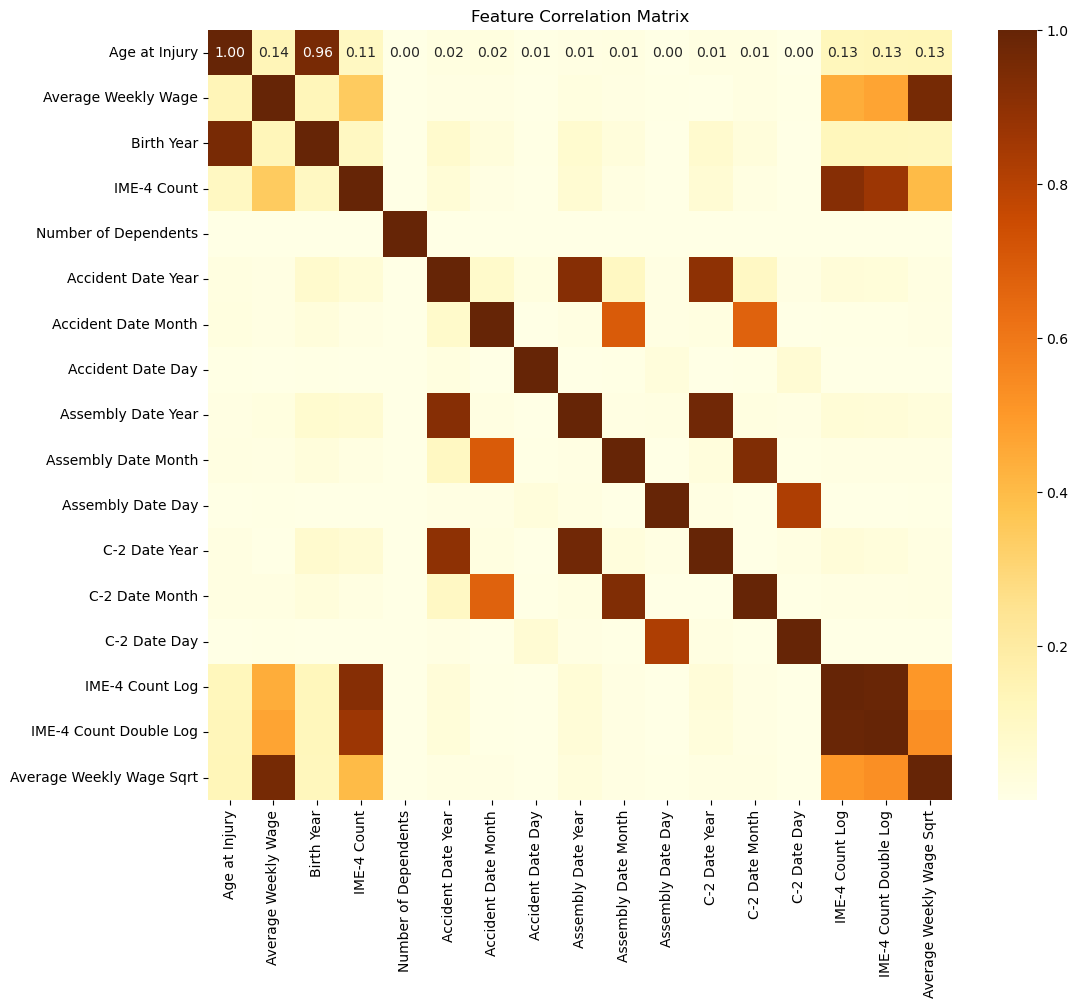

In [62]:
# Visualize the correlation matrix to identify relationships between numerical features
fs.correlation_matrix(X_train[num])

**Chi Squared Test**

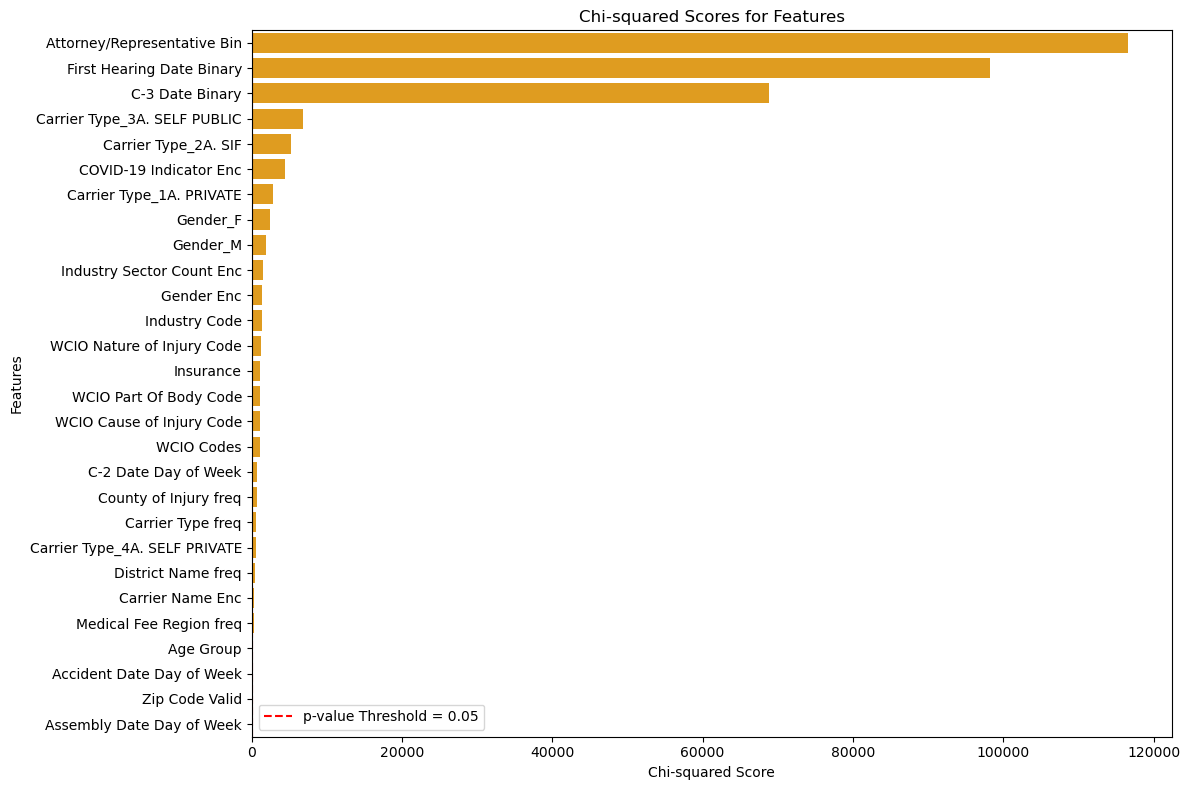


Initial Features: 28

['Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Carrier Name Enc', 'Carrier Type freq', 'County of Injury freq', 'District Name freq', 'Medical Fee Region freq', 'Accident Date Day of Week', 'Assembly Date Day of Week', 'C-2 Date Day of Week', 'WCIO Codes', 'Industry Sector Count Enc', 'Attorney/Representative Bin', 'Carrier Type_1A. PRIVATE', 'Carrier Type_2A. SIF', 'Carrier Type_3A. SELF PUBLIC', 'Carrier Type_4A. SELF PRIVATE', 'COVID-19 Indicator Enc', 'Gender Enc', 'Gender_F', 'Gender_M', 'Zip Code Valid', 'Age Group', 'C-3 Date Binary', 'First Hearing Date Binary', 'Insurance']

Decision for Categorical Features (p-value < threshold): 25

['Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Carrier Name Enc', 'Carrier Type freq', 'County of Injury freq', 'District Name freq', 'Medical Fee Region freq', 'C-2 Date Day of Week', 'WCIO Codes', 'Industry Se

In [63]:
fs.chi_squared(X_train_all_categ, y_train)

**Mutual Information Test**

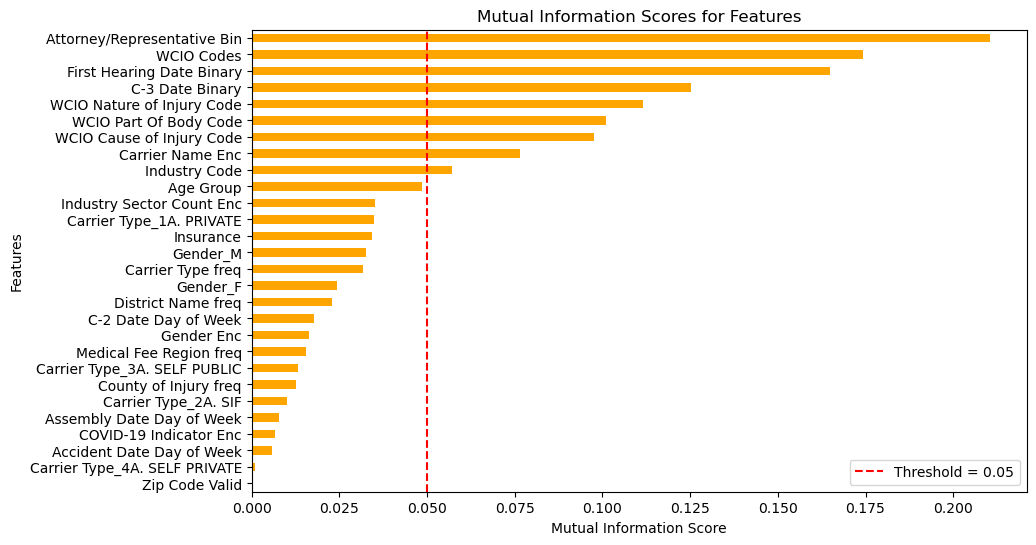


Initial Features: 28 

['Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Carrier Name Enc', 'Carrier Type freq', 'County of Injury freq', 'District Name freq', 'Medical Fee Region freq', 'Accident Date Day of Week', 'Assembly Date Day of Week', 'C-2 Date Day of Week', 'WCIO Codes', 'Industry Sector Count Enc', 'Attorney/Representative Bin', 'Carrier Type_1A. PRIVATE', 'Carrier Type_2A. SIF', 'Carrier Type_3A. SELF PUBLIC', 'Carrier Type_4A. SELF PRIVATE', 'COVID-19 Indicator Enc', 'Gender Enc', 'Gender_F', 'Gender_M', 'Zip Code Valid', 'Age Group', 'C-3 Date Binary', 'First Hearing Date Binary', 'Insurance']

Decision for Categorical Features (MI Score >= 0.05): 9 

['Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Carrier Name Enc', 'WCIO Codes', 'Attorney/Representative Bin', 'C-3 Date Binary', 'First Hearing Date Binary']


In [64]:
fs.mutual_info(X_train_all_categ, y_train, threshold = 0.05)

## 3.3 Wrapper Methods

<a href="#top">Top &#129033;</a>

Unlike filter methods, which assess features independently, wrapper methods evaluate the effectiveness of feature subsets by measuring the model’s performance, making them more computationally expensive but often more accurate in selecting relevant features.

**Recursive Feature Elimination (RFE) - Logistic Regression**

In [ ]:
# Perform Recursive Feature Elimination (RFE) to select the top features based on their importance for a logistic regression model
n_features = np.arange(2, len(X_train[num].columns) + 1)
model = LogisticRegression()
fs.rfe(X_train[num], y_train, n_features = n_features, model = model)

# ~20 min

Selected Features:

['Age at Injury',
 'Average Weekly Wage',
 'Birth Year',
 'IME-4 Count',
 'Accident Date Year',
 'Assembly Date Year',
 'C-2 Date Year',
 'IME-4 Count Log']

**Recursive Feature Elimination (RFE) - Random Forest Classifier**

In [ ]:
# Perform Recursive Feature Elimination (RFE) to select the top features based on their importance for a logistic regression model
n_features = np.arange(2, len(X_train[num].columns) + 1)
model = RandomForestClassifier()
fs.rfe(X_train[num], y_train, n_features = n_features, model = model)

# 

Selected Features:

['Age at Injury',
 'Average Weekly Wage',
 'Birth Year',
 'IME-4 Count',
 'Number of Dependents',
 'Accident Date Year',
 'Accident Date Month',
 'Accident Date Day',
 'Assembly Date Year',
 'Assembly Date Month',
 'Assembly Date Day',
 'C-2 Date Year',
 'C-2 Date Month',
 'C-2 Date Day',
 'IME-4 Count Log',
 'IME-4 Count Double Log']

## 3.4 Embedded Methods

<a href="#top">Top &#129033;</a>

These methods use algorithms that inherently select features as part of the model’s learning process. Embedded methods are computationally efficient and tend to be more accurate than filter methods, as they consider feature interactions and model performance simultaneously.


**Least Absolute Shrinkage and Selection Operator (LASSO)**

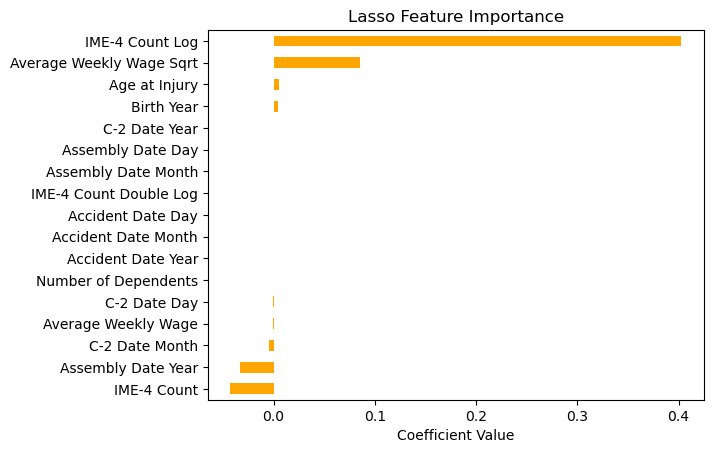


Initial Features: 17

['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Number of Dependents', 'Accident Date Year', 'Accident Date Month', 'Accident Date Day', 'Assembly Date Year', 'Assembly Date Month', 'Assembly Date Day', 'C-2 Date Year', 'C-2 Date Month', 'C-2 Date Day', 'IME-4 Count Log', 'IME-4 Count Double Log', 'Average Weekly Wage Sqrt']

Decision for Numerical Features (lasso ≠ 0): 9

['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Assembly Date Year', 'C-2 Date Month', 'C-2 Date Day', 'IME-4 Count Log', 'Average Weekly Wage Sqrt']


In [65]:
fs.lasso(X_train[num], y_train, alpha = 0.01)

**Extra Trees Classifier**

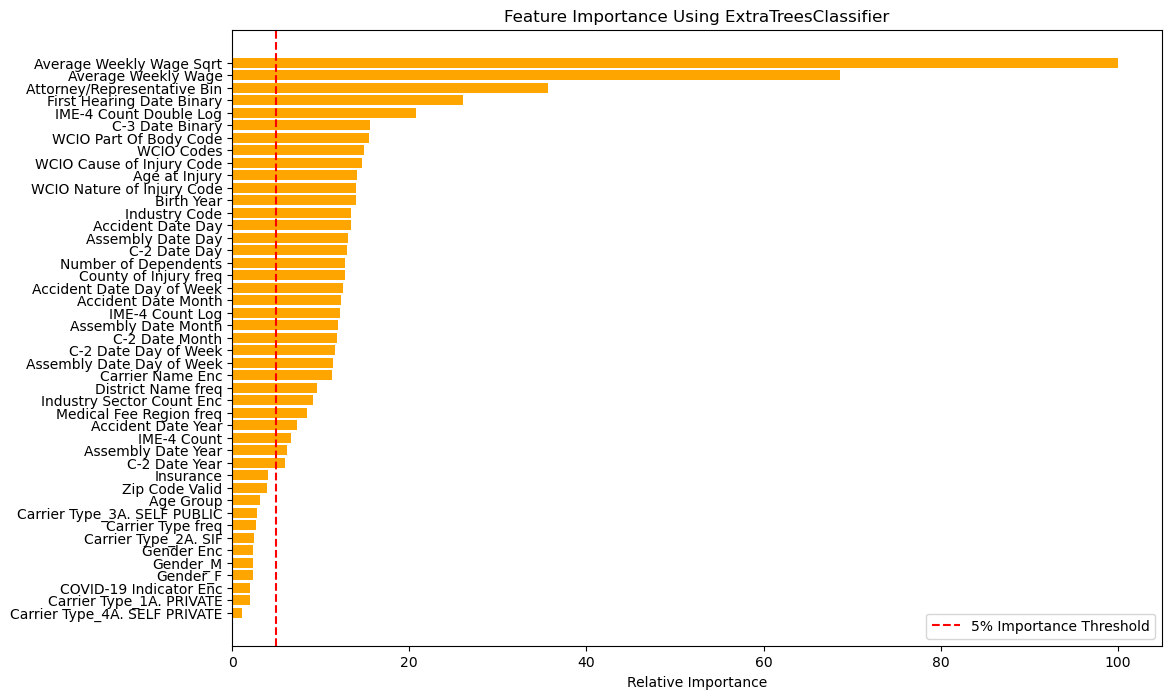


Initial Features: 45

['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Number of Dependents', 'Accident Date Year', 'Accident Date Month', 'Accident Date Day', 'Assembly Date Year', 'Assembly Date Month', 'Assembly Date Day', 'C-2 Date Year', 'C-2 Date Month', 'C-2 Date Day', 'IME-4 Count Log', 'IME-4 Count Double Log', 'Average Weekly Wage Sqrt', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Carrier Name Enc', 'Carrier Type freq', 'County of Injury freq', 'District Name freq', 'Medical Fee Region freq', 'Accident Date Day of Week', 'Assembly Date Day of Week', 'C-2 Date Day of Week', 'WCIO Codes', 'Industry Sector Count Enc', 'Attorney/Representative Bin', 'Carrier Type_1A. PRIVATE', 'Carrier Type_2A. SIF', 'Carrier Type_3A. SELF PUBLIC', 'Carrier Type_4A. SELF PRIVATE', 'COVID-19 Indicator Enc', 'Gender Enc', 'Gender_F', 'Gender_M', 'Zip Code Valid', 'Age Group', 'C-3 Date Binary', 'First Hearing Date Bin

In [66]:
fs.plot_feature_importance(X_train[num], X_train_all_categ, y_train, 
                        n_estimators = 250)

[Go to Modeling &#129034;](#modeling)

** **

**<center>Numeric Variables</center>**





| Variable                   | Variance | Correlation | RFE LR | RFE RF | Lasso       | Extra Trees | `Decision` |
|----------------------------|----------|-------------|--------|--------|-------------|-------------|------------|
| -------------------------- | -------- | ----------- | ------ | ------ | ----------- | ----------- | ---------- |
| -------------------------- | -------- | ----------- | ------ | ------ | ----------- | ----------- | ---------- |
| -------------------------- | -------- | ----------- | ------ | ------ | ----------- | ----------- | ---------- |
| -------------------------- | -------- | ----------- | ------ | ------ | ----------- | ----------- | ---------- |
| -------------------------- | -------- | ----------- | ------ | ------ | ----------- | ----------- | ---------- |
| -------------------------- | -------- | ----------- | ------ | ------ | ----------- | ----------- | ---------- |
| -------------------------- | -------- | ----------- | ------ | ------ | ----------- | ----------- | ---------- |
| -------------------------- | -------- | ----------- | ------ | ------ | ----------- | ----------- | ---------- |
| -------------------------- | -------- | ----------- | ------ | ------ | ----------- | ----------- | ---------- |
| -------------------------- | -------- | ----------- | ------ | ------ | ----------- | ----------- | ---------- |
| -------------------------- | -------- | ----------- | ------ | ------ | ----------- | ----------- | ---------- |
| -------------------------- | -------- | ----------- | ------ | ------ | ----------- | ----------- | ---------- |
| -------------------------- | -------- | ----------- | ------ | ------ | ----------- | ----------- | ---------- |
| -------------------------- | -------- | ----------- | ------ | ------ | ----------- | ----------- | ---------- |
| -------------------------- | -------- | ----------- | ------ | ------ | ----------- | ----------- | ---------- |
| -------------------------- | -------- | ----------- | ------ | ------ | ----------- | ----------- | ---------- |
| -------------------------- | -------- | ----------- | ------ | ------ | ----------- | ----------- | ---------- |
| -------------------------- | -------- | ----------- | ------ | ------ | ----------- | ----------- | ---------- |
| -------------------------- | -------- | ----------- | ------ | ------ | ----------- | ----------- | ---------- |
| -------------------------- | -------- | ----------- | ------ | ------ | ----------- | ----------- | ---------- |


**<center>Categorical Variables</center>**

| Variable                              | Chi-Squared | MI          | Extra trees | Decision    |
|---------------------------------------|-------------|-------------|-------------|-------------|
| ------------------------------------- | ----------- | ----------- | ----------- | ----------- |
| ------------------------------------- | ----------- | ----------- | ----------- | ----------- |
| ------------------------------------- | ----------- | ----------- | ----------- | ----------- |
| ------------------------------------- | ----------- | ----------- | ----------- | ----------- |
| ------------------------------------- | ----------- | ----------- | ----------- | ----------- |
| ------------------------------------- | ----------- | ----------- | ----------- | ----------- |
| ------------------------------------- | ----------- | ----------- | ----------- | ----------- |
| ------------------------------------- | ----------- | ----------- | ----------- | ----------- |
| ------------------------------------- | ----------- | ----------- | ----------- | ----------- |
| ------------------------------------- | ----------- | ----------- | ----------- | ----------- |
| ------------------------------------- | ----------- | ----------- | ----------- | ----------- |
| ------------------------------------- | ----------- | ----------- | ----------- | ----------- |
| ------------------------------------- | ----------- | ----------- | ----------- | ----------- |
| ------------------------------------- | ----------- | ----------- | ----------- | ----------- |



## 3.4 Final Features

<a href="#top">Top &#129033;</a>

# 4. Modeling

<a class="anchor" id="modeling"></a>

[Go to Feature Selection &#129034;](#feature-selection)

<a href="#top">Top &#129033;</a>

Start by importing the correct datasets.


In [42]:
from sklearn.linear_model import LogisticRegression, SGDClassifier  # Linear models
from sklearn.tree import DecisionTreeClassifier  
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis  # Discriminant analysis models
from xgboost import XGBClassifier   
from sklearn.neural_network import MLPClassifier

In [41]:
# X_train = pd.read_csv('./data/X_train_treated.csv', index_col = 'Claim Identifier')
# X_val = pd.read_csv('./data/X_val_treated.csv', index_col = 'Claim Identifier')
# y_train = pd.read_csv('./data/y_train_treated.csv', index_col = 'Claim Identifier')
# y_val = pd.read_csv('./data/y_val_treated.csv', index_col = 'Claim Identifier')
# test = pd.read_csv('./data/test_treated.csv', index_col = 'Claim Identifier')

And select the columns to use for predictions purposes

In [ ]:
columns = []

X_train_filtered = X_train[columns]
X_val_filtered = X_val[columns]
test_filtered = test[columns]

**Baseline Model**

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

In [ ]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)

In [ ]:
m.metrics(y_train, train_pred, y_val, val_pred)

**SGD Classifier**

In [ ]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)

In [ ]:
# Predict the target values for the training 
train_pred_sgd = sgd.predict(X_train)

# Predict the target values for the validation
val_pred_sgd = sgd.predict(X_val)

In [ ]:
# Evaluate the performance of the SGDClassifier
m.metrics(y_train, train_pred_sgd, y_val, val_pred_sgd)

**Decision Tree Classifier**

In [47]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [48]:
# Predict the target values for the training
train_pred_dt = dt.predict(X_train)

# Predict the target values for the validation
val_pred_dt = dt.predict(X_val)

In [49]:
# Evaluate the performance of the DecisionTreeClassifier
m.metrics(y_train, train_pred_dt, y_val, val_pred_dt)

______________________________________________________________________
                                TRAIN                                 
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9498
           1       1.00      1.00      1.00    229235
           2       1.00      1.00      1.00     54891
           3       1.00      1.00      1.00    117056
           4       1.00      1.00      1.00     38502
           5       1.00      1.00      1.00      3359
           6       1.00      1.00      1.00        77
           7       1.00      1.00      1.00       374

    accuracy                           1.00    452992
   macro avg       1.00      1.00      1.00    452992
weighted avg       1.00      1.00      1.00    452992

______________________________________________________________________
                                VALIDATION                       

**Random Forest Classifier**

In [50]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [51]:
# Predict the target values for the training
train_pred_rf = rf.predict(X_train)

# Predict the target values for the validation
val_pred_rf = rf.predict(X_val)

In [52]:
m.metrics(y_train, train_pred_rf, y_val, val_pred_rf)

______________________________________________________________________
                                TRAIN                                 
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9498
           1       1.00      1.00      1.00    229235
           2       1.00      1.00      1.00     54891
           3       1.00      1.00      1.00    117056
           4       1.00      1.00      1.00     38502
           5       1.00      1.00      1.00      3359
           6       1.00      1.00      1.00        77
           7       1.00      1.00      1.00       374

    accuracy                           1.00    452992
   macro avg       1.00      1.00      1.00    452992
weighted avg       1.00      1.00      1.00    452992

______________________________________________________________________
                                VALIDATION                       

**Gradient Boosting Classifier**

In [53]:
# Initialize the GradientBoostingClassifier 
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

GradientBoostingClassifier()

In [54]:
# Predict the target values for the training 
train_pred_gb = gb.predict(X_train)

# Predict the target values for the validation
val_pred_gb = gb.predict(X_val)

In [55]:
# Evaluate the performance of the GradientBoostingClassifier
m.metrics(y_train, train_pred_gb, y_val, val_pred_gb)

______________________________________________________________________
                                TRAIN                                 
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.49      0.59      9498
           1       0.85      0.96      0.90    229235
           2       0.51      0.06      0.11     54891
           3       0.69      0.89      0.77    117056
           4       0.70      0.55      0.62     38502
           5       0.64      0.01      0.01      3359
           6       0.58      0.09      0.16        77
           7       0.31      0.21      0.25       374

    accuracy                           0.78    452992
   macro avg       0.63      0.41      0.43    452992
weighted avg       0.75      0.78      0.73    452992

______________________________________________________________________
                                VALIDATION                       

[Go to Modeling &#129034;](#modeling)

<a href="#top">Top &#129033;</a>
<br>

**AdaBoost Classifier**

In [56]:
# Initialize the AdaBoostClassifier
ab = AdaBoostClassifier()
ab.fit(X_train, y_train)

AdaBoostClassifier()

In [57]:
# Predict the target values for the training
train_pred_ab = ab.predict(X_train)

# Predict the target values for the validation
val_pred_ab = ab.predict(X_val)

In [58]:
# Evaluate the performance of the AdaBoostClassifier 
m.metrics(y_train, train_pred_ab, y_val, val_pred_ab)

______________________________________________________________________
                                TRAIN                                 
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.17      0.63      0.27      9498
           1       0.85      0.84      0.85    229235
           2       0.42      0.04      0.07     54891
           3       0.63      0.89      0.74    117056
           4       0.56      0.30      0.39     38502
           5       0.00      0.00      0.00      3359
           6       0.01      0.04      0.01        77
           7       0.20      0.58      0.30       374

    accuracy                           0.70    452992
   macro avg       0.35      0.41      0.33    452992
weighted avg       0.70      0.70      0.67    452992

______________________________________________________________________
                                VALIDATION                       

In [59]:
import play_song as s
s.play_('audio.mp3')

Input #0, wav, from '/var/folders/mm/fxsq_1490x9dd2w76tqvt3kr0000gn/T/tmpto58sqov.wav':
  Duration: 00:00:10.00, bitrate: 1536 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, 2 channels, s16, 1536 kb/s


**Linear Discriminant Analysis**

In [ ]:
# Initialize the Linear Discriminant Analysis (LDA)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_filtered, y_train)

In [ ]:
# Predict the target values for the training
train_pred_lda = lda.predict(X_train_filtered)

# Predict the target values for the validation
val_pred_lda = lda.predict(X_val_filtered)

In [ ]:
# Evaluate the performance of the Linear Discriminant Analysis (LDA)
m.metrics(y_train, train_pred_lda, y_val, val_pred_lda)

**Quadratic Discriminant Analysis**

In [ ]:
# Initialize the Quadratic Discriminant Analysis (QDA)
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_filtered, y_train)

In [ ]:
# Predict the target values for the training dataset 
train_pred_qda = qda.predict(X_train_filtered)

# Predict the target values for the validation 
val_pred_qda = qda.predict(X_val_filtered)

In [ ]:
# Evaluate the performance of the Quadratic Discriminant Analysis (QDA)
m.metrics(y_train, train_pred_qda, y_val, val_pred_qda)

[Go to Modeling &#129034;](#modeling)

<a href="#top">Top &#129033;</a>

<br>

**XGB Classifier**

In [43]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [44]:
# Predict the target values for the training dataset
train_pred_xgb = xgb.predict(X_train)
# Predict the target values for the validation 
val_pred_xgb = xgb.predict(X_val)

In [45]:
m.metrics(y_train, train_pred_xgb , y_val, val_pred_xgb)

______________________________________________________________________
                                TRAIN                                 
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.57      0.66      9498
           1       0.86      0.97      0.91    229235
           2       0.64      0.10      0.17     54891
           3       0.72      0.89      0.80    117056
           4       0.72      0.65      0.68     38502
           5       0.93      0.06      0.11      3359
           6       1.00      0.95      0.97        77
           7       0.99      0.98      0.98       374

    accuracy                           0.80    452992
   macro avg       0.83      0.64      0.66    452992
weighted avg       0.79      0.80      0.76    452992

______________________________________________________________________
                                VALIDATION                       

In [46]:
import play_song as s
s.play_('audio.mp3')

Input #0, wav, from '/var/folders/mm/fxsq_1490x9dd2w76tqvt3kr0000gn/T/tmpwbm5g75s.wav':
  Duration: 00:00:10.00, bitrate: 1536 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, 2 channels, s16, 1536 kb/s


**Neural Networks**

In [ ]:
model = MLPClassifier(hidden_layer_sizes=(15,17,18,19,20),learning_rate_init=0.1, activation='relu', solver='sgd', batch_size=500, learning_rate="adaptive" )
model.fit(X_train_filtered, y_train)

In [ ]:
train_pred_neural = model.predict(X_train_filtered)
val_pred_neural = model.predict(X_val_filtered)

In [ ]:
m.metrics(y_train, train_pred_neural, y_val, val_pred_neural)

## 4.2 Combining Models

[Go to Modeling &#129034;](#modeling)

<a href="#top">Top &#129033;</a>


Combining models, also known as ensemble learning, involves integrating multiple machine learning models to improve predictive performance. In this section, we will explore methods for combining models, evaluate their performance, and demonstrate how ensemble techniques can lead to more reliable and effective predictions compared to single models.


**Voting Classifier**

**Stacking Classifier**

<br>

**<center>Best Performing Models<center>**
    
** **
    
| Model | Macro-f1 Score |
| ----- | -------------- |
| XGB | 0.42983 |
| RF | -------------- |
| ----- | -------------- |
| ----- | -------------- |
| ----- | -------------- |

## 4.3 Hyperparameter Tuning

[Go to Modeling &#129034;](#modeling)

<a href="#top">Top &#129033;</a>

## 4.4 Final Predictions

[Go to Modeling &#129034;](#modeling)

<a href="#top">Top &#129033;</a>

In [ ]:
test_filtered = test[X_train.columns]

In [ ]:
test_filtered['Claim Injury Type'] = xgb.predict(test_filtered)

Map Predictions to Original Values

In [ ]:
label_mapping = {
    0: "1. CANCELLED",
    1: "2. NON-COMP",
    2: "3. MED ONLY",
    3: "4. TEMPORARY",
    4: "5. PPD SCH LOSS",
    5: "6. PPD NSL",
    6: "7. PTD",
    7: "8. DEATH"
}


test_filtered['Claim Injury Type'] = test_filtered['Claim Injury Type'].replace(label_mapping)

In [ ]:
# Count unique values in column 'Claim Injury Type'
test_filtered['Claim Injury Type'].value_counts() 

In [ ]:
# Extract the target variable 'Claim Injury Type' from the test dataset for prediction
predictions = test_filtered['Claim Injury Type']

**Export Predictions**

In [ ]:
# Assign a descriptive name for easy reference
name = 'all_feat_xgb'

# Save the predictions to a CSV file.
predictions.to_csv(f'./pred/{name}.csv')